# Relevant Imports

In [1]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['PYTHONHASHSEED'] = str(50)

# Test Set: Normalized Global Dataset

### Load RTT Data

In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')

# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

print(f'Columns:')
for i in X.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '')


Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

### Distribute data among clients

In [3]:
seed = 11

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X = scaler.fit_transform(X)

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.SetValData({'Val Data': X_val, 'Val Labels': y_val})
fed.SetTestData({'Data': X, 'Labels': y})

### ConFeddi with $\alpha = 0.01$ and $\lambda = 0.1$

In [ ]:
Mt = (np.ones(50) * 5).astype('int32')
fed.SetContextElements([0])
w, b = fed.ConFeddi(.01, .1, rounds = 50, Mt = Mt)
conf_test_mse = fed.test_loss()
conf_log = fed.GetLog()
fed.clear_history()

Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50


### Load FedAvg Baseline data tested on normalized global dataset

In [ ]:
fedavg_test_mse = np.load('history/important baselines/fedavg_test_mse.npy')
fedavg_log = np.load('history/important baselines/fedavg_log.npy')

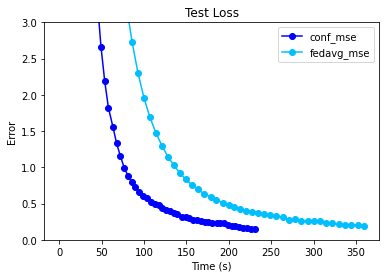

In [ ]:
plt.ylim(0, 3)
plt.plot(conf_log, conf_test_mse, color = 'blue', label = 'conf_mse', marker = 'o')
plt.plot(fedavg_log, fedavg_test_mse, color = 'deepskyblue', label = 'fedavg_mse', marker = 'o')
plt.title(f'Test Loss')
plt.ylabel('Error')
plt.xlabel('Time (s)')
plt.legend()


0.7677301157663243


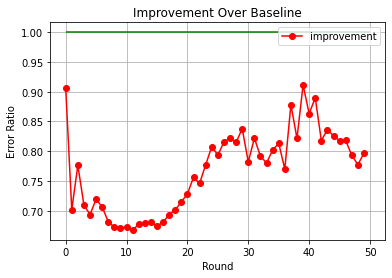

In [ ]:
ratios = np.array(conf_test_mse[1:]) / np.array(fedavg_test_mse[1:])
plt.plot(ratios, color = 'red', label = 'improvement', marker = 'o')
plt.title('Improvement Over Baseline')
plt.ylabel('Error Ratio')
plt.xlabel('Round')
plt.hlines(1, 0, 50, color = 'green')
plt.grid()
plt.legend()
print(f'Achieved {ratios.mean() * 100:.2f}% average of FedAvg loss')

In [ ]:
score = (conf_log[1:] / fedavg_log[1:]) * ratios
score = 1 - score.mean()
if score < 0:
    score = 0
print(f'Model Score: {score}')
print(f'Final FedAvg Test Error: {fedavg_test_mse[-1]}')
print(f'Final ConFeddi Test Error: {conf_test_mse[-1]}')

Model Score: 0.47890685941010236
Final FedAvg Test Error: 0.19175423681735992
Final ConFeddi Test Error: 0.1527545154094696


# Ablation Study

In [ ]:
history = dict()
base_mse = dict()
base_log = dict()
Mt = (np.ones(50) * 5).astype('int32')
count = 1

context_elements = [
    [0, 1, 2, 3, 4],
    [0],
    [1],
    [2],
    [3],
    [4],
    [1, 2, 3, 4],
    [0, 2, 3, 4],
    [0, 1, 3, 4],
    [0, 1, 2, 4],
    [0, 1, 2, 3]
]

In [ ]:
tf.keras.utils.set_random_seed(50)
tf.config.experimental.enable_op_determinism()

for context in context_elements:
    print(f'Training Model {count}')
    fed.SetContextElements(context)
    w, b = fed.ConFeddi(0.01, 0.1, rounds = 50, Mt = Mt)
    mse = fed.test_loss()
    log = fed.GetLog()
    history[tuple(context)] = (mse, log)
    count += 1

    if context == [0, 1, 2, 3, 4]:
        base_mse[tuple(context)] = mse
        base_log[tuple(context)] = log
    fed.clear_history()
    print()


Training Model 1
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 2
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 3
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 4
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 5
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 6
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 7
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 8
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 9
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 10
Round 5
Round 10
Ro

Final FedAvg: 0.19175423681735992
context = (0,), True, Final Test Error: 0.16464963555335999
context = (1,), False, Final Test Error: 0.40543290972709656
context = (2,), False, Final Test Error: 0.26847386360168457
context = (3,), False, Final Test Error: 0.24785490334033966
context = (4,), True, Final Test Error: 0.1813766062259674
context = (1, 2, 3, 4), True, Final Test Error: 0.1439400017261505
context = (0, 2, 3, 4), False, Final Test Error: 0.3275684118270874
context = (0, 1, 3, 4), False, Final Test Error: 0.23190276324748993
context = (0, 1, 2, 4), False, Final Test Error: 0.3334546387195587
context = (0, 1, 2, 3), False, Final Test Error: 0.2918584942817688


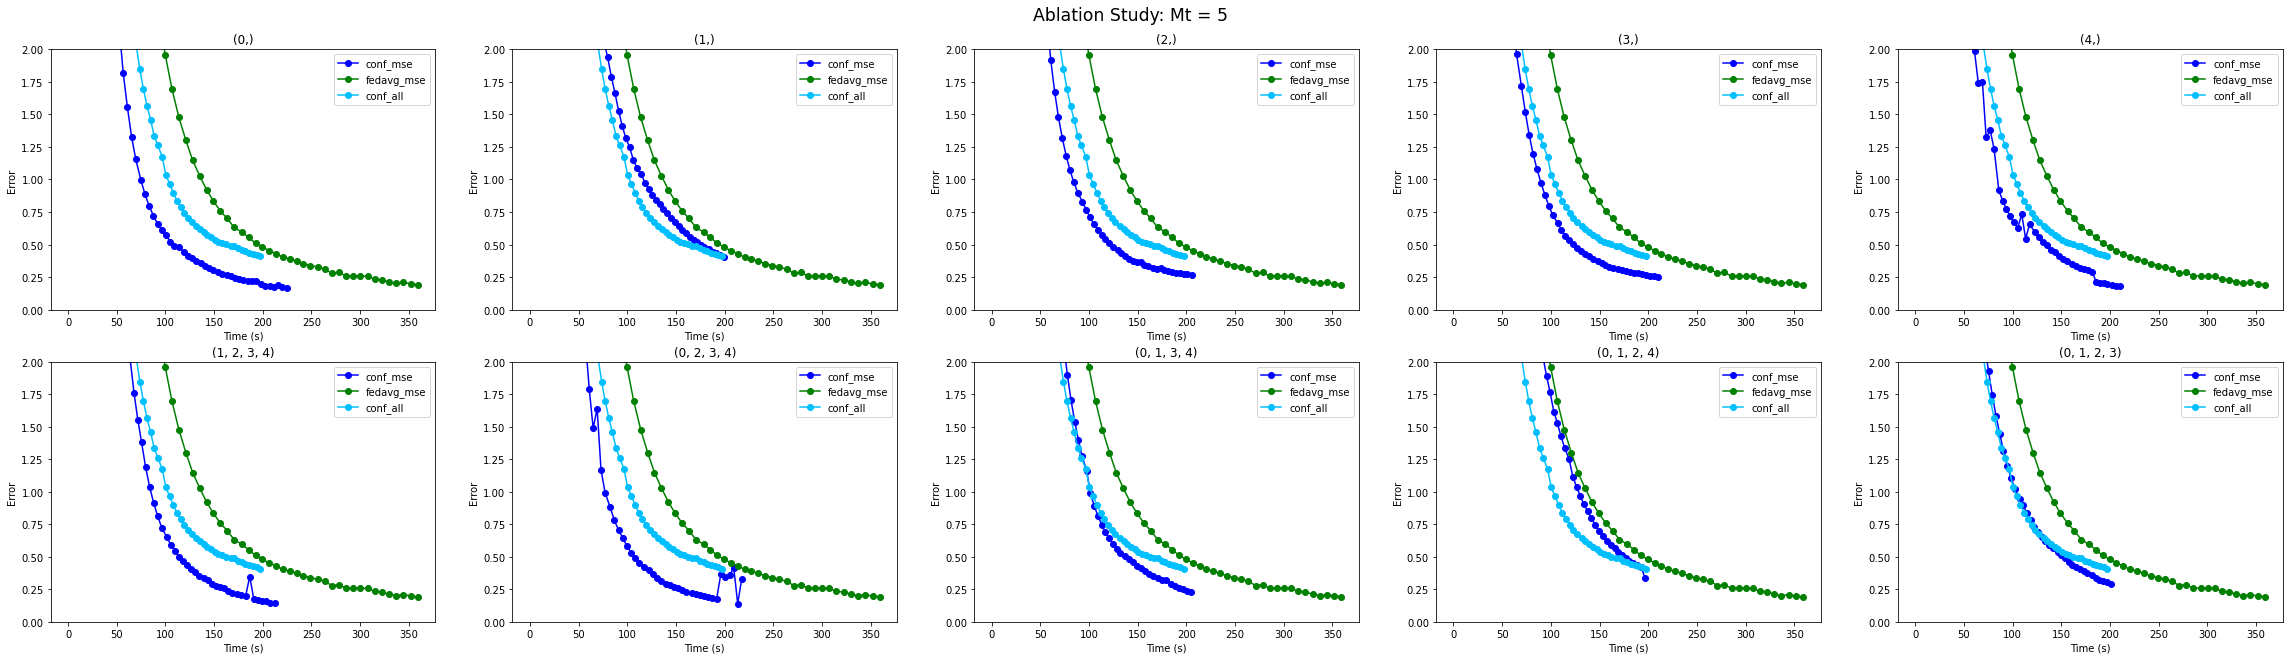

In [ ]:
r, c, = 2, 5
fig = plt.figure(figsize = (40, 10))
plt.suptitle('Ablation Study: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)
print(f'Final FedAvg: {fedavg_test_mse[-1]}')

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_test_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
    

    plt.plot(base_log[tuple([0, 1, 2, 3, 4])], base_mse[tuple([0, 1, 2, 3, 4])], color = 'deepskyblue', label = 'conf_all', marker = 'o')

    # When using final a and l, change title to Remove <specific context>
    plt.title(f'{context}')
    plt.ylim(0, 2)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.legend()

    print(f'context = {context}, Final Test Error: {err[-1]}', {fedavg_test_mse[-1] > err[-1]})

    plot += 1

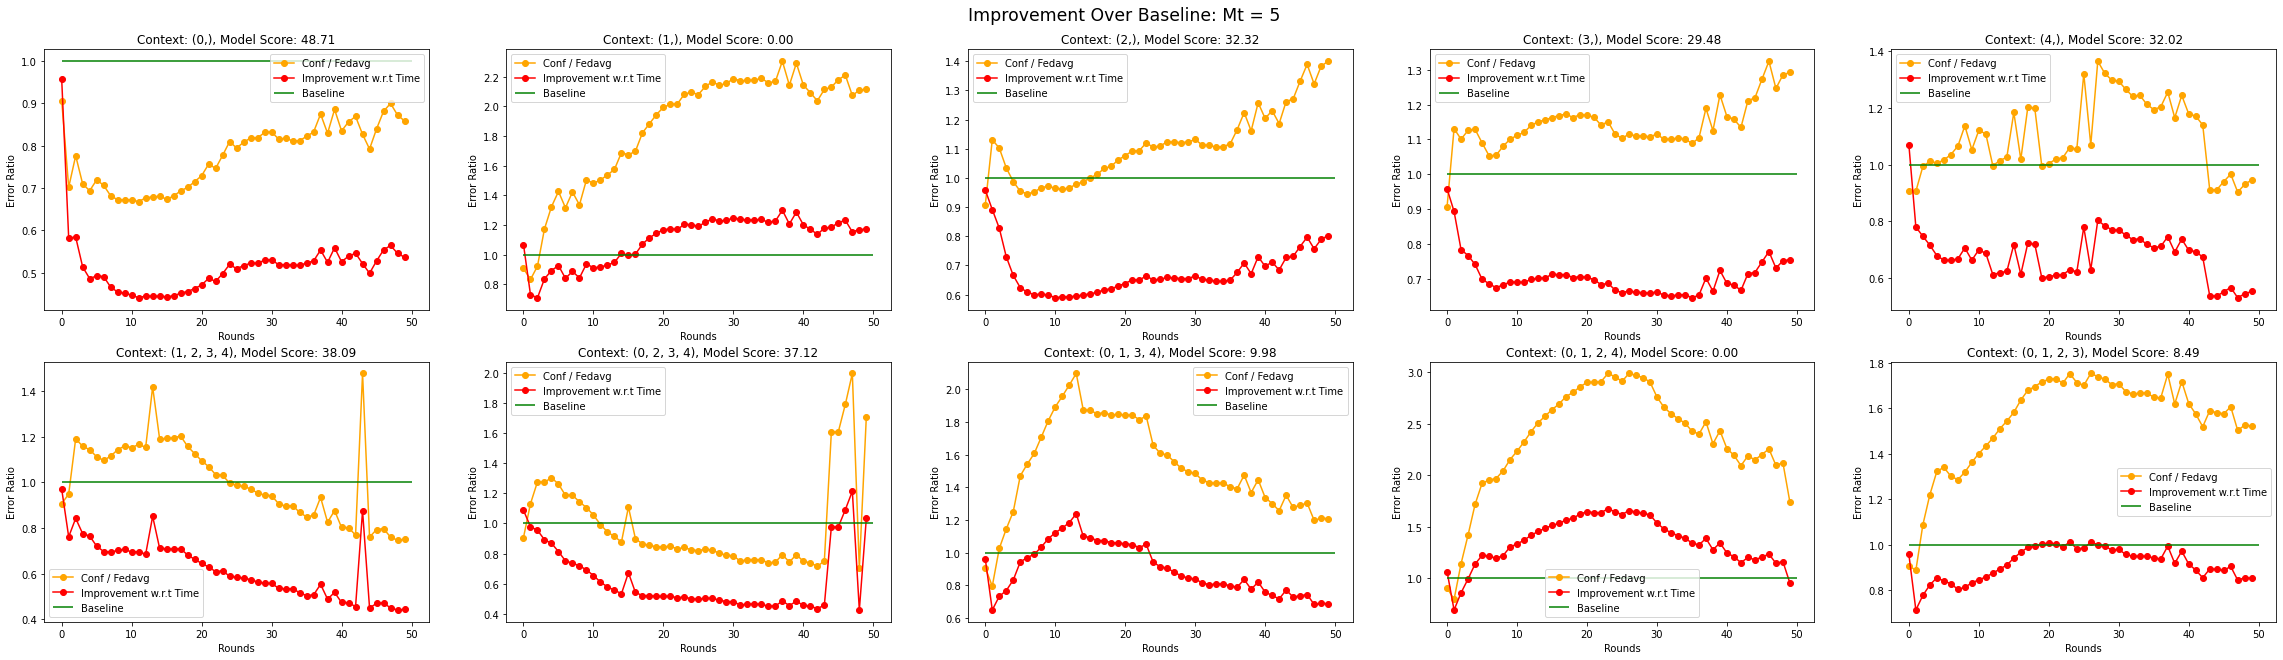

In [ ]:
r, c, = 2, 5
fig = plt.figure(figsize = (40, 10))
plt.suptitle('Improvement Over Baseline: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)

    ratios = np.array(err[1:]) / np.array(fedavg_test_mse[1:]) 
    scale = np.array(time[1:]) / np.array(fedavg_log[1:])
    timescaled = scale * ratios
    plt.plot(ratios, color = 'red', label = 'Conf / Fedavg', marker = 'o')
    score = 1 - timescaled.mean()
    if score < 0: score = 0
    plt.title(f'Context: {context}, Model Score: {score * 100:.2f}')
    plt.ylabel('Error Ratio')
    plt.xlabel('Rounds')
    plt.hlines(1, 0, 50, color = 'green', label = 'Baseline')
    plt.legend()


    plot += 1

# Using completely separate test set

### Split Data

In [2]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')
print(f'Columns:')
for i in data.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '')

# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

In [8]:
seed = 11

# 60 20 20 split
X_split, X_val, y_split, y_val = train_test_split(X, y, test_size = 0.20, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size = 0.25, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.SetValData({'Val Data': X_val, 'Val Labels': y_val})
fed.SetTestData({'Data': X_test, 'Labels': y_test})

In [9]:
total_x = 0
total_y = 0
for a, b in zip(data['Client Data'], data['Client Labels']):
    total_x += len(a)
    total_y += len(b)
print(f'Total Client Training Samples: {total_x}')
print(f'Total Client Training Labels: {total_y}')
print(f'Total Validation Samples: {len(X_val)}')
print(f'Total Validation Labels: {len(y_val)}')
print(f'Total Test Samples: {len(X_test)}')
print(f'Total Test Labels: {len(y_test)}')

Total Client Training Samples: 17748
Total Client Training Labels: 17748
Total Validation Samples: 5917
Total Validation Labels: 5917
Total Test Samples: 5916
Total Test Labels: 5916


### Grid Analysis

In [11]:
rounds = 50
a_search = np.logspace(-2, 3, 6)
l_search = np.logspace(-3, 1, 5)
history = dict()
Mt = (np.ones(rounds) * 5).astype('int32')
count = 1
for a in a_search:
    for l in l_search:
        print(f'Training Model {count}')
        w, b = fed.ConFeddi(a, l, rounds = rounds, Mt = Mt)
        history[(a, l)] = (fed.test_loss(), fed.GetLog())
        count += 1
        fed.clear_history()
        print()

Training Model 1
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 2
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 3
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 4
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 5
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 6
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 7
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 8
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 9
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 10
Round 5
Round 10
Ro

### Load FedAvg Baseline data tested on similarly split training, validation, and test sets

In [4]:
fedavg_test_mse = np.load('history/important baselines/fedavg_test_mse_sep.npy')
fedavg_val_mse = np.load('history/important baselines/fedavg_val_mse_sep.npy')
fedavg_log = np.load('history/important baselines/fedavg_log_sep.npy')

Final FedAvg Test MSE: 0.3371109366416931
a = 0.01, l = 0.001, Final mse: 0.3111020028591156, True
a = 0.01, l = 0.01, Final mse: 0.35817885398864746, False
a = 0.01, l = 0.1, Final mse: 0.302076131105423, True
a = 0.01, l = 1.0, Final mse: 0.281379759311676, True
a = 0.01, l = 10.0, Final mse: 0.3246474266052246, True
a = 0.1, l = 0.001, Final mse: 0.3416454792022705, False
a = 0.1, l = 0.01, Final mse: 0.32919731736183167, True
a = 0.1, l = 0.1, Final mse: 0.31393322348594666, True
a = 0.1, l = 1.0, Final mse: 0.320566326379776, True
a = 0.1, l = 10.0, Final mse: 0.31216591596603394, True
a = 1.0, l = 0.001, Final mse: 0.7013040781021118, False
a = 1.0, l = 0.01, Final mse: 0.38422465324401855, False
a = 1.0, l = 0.1, Final mse: 0.7848277688026428, False
a = 1.0, l = 1.0, Final mse: 0.32696765661239624, True
a = 1.0, l = 10.0, Final mse: 0.40537768602371216, False
a = 10.0, l = 0.001, Final mse: 0.3216371238231659, True
a = 10.0, l = 0.01, Final mse: 0.34166356921195984, False
a = 10

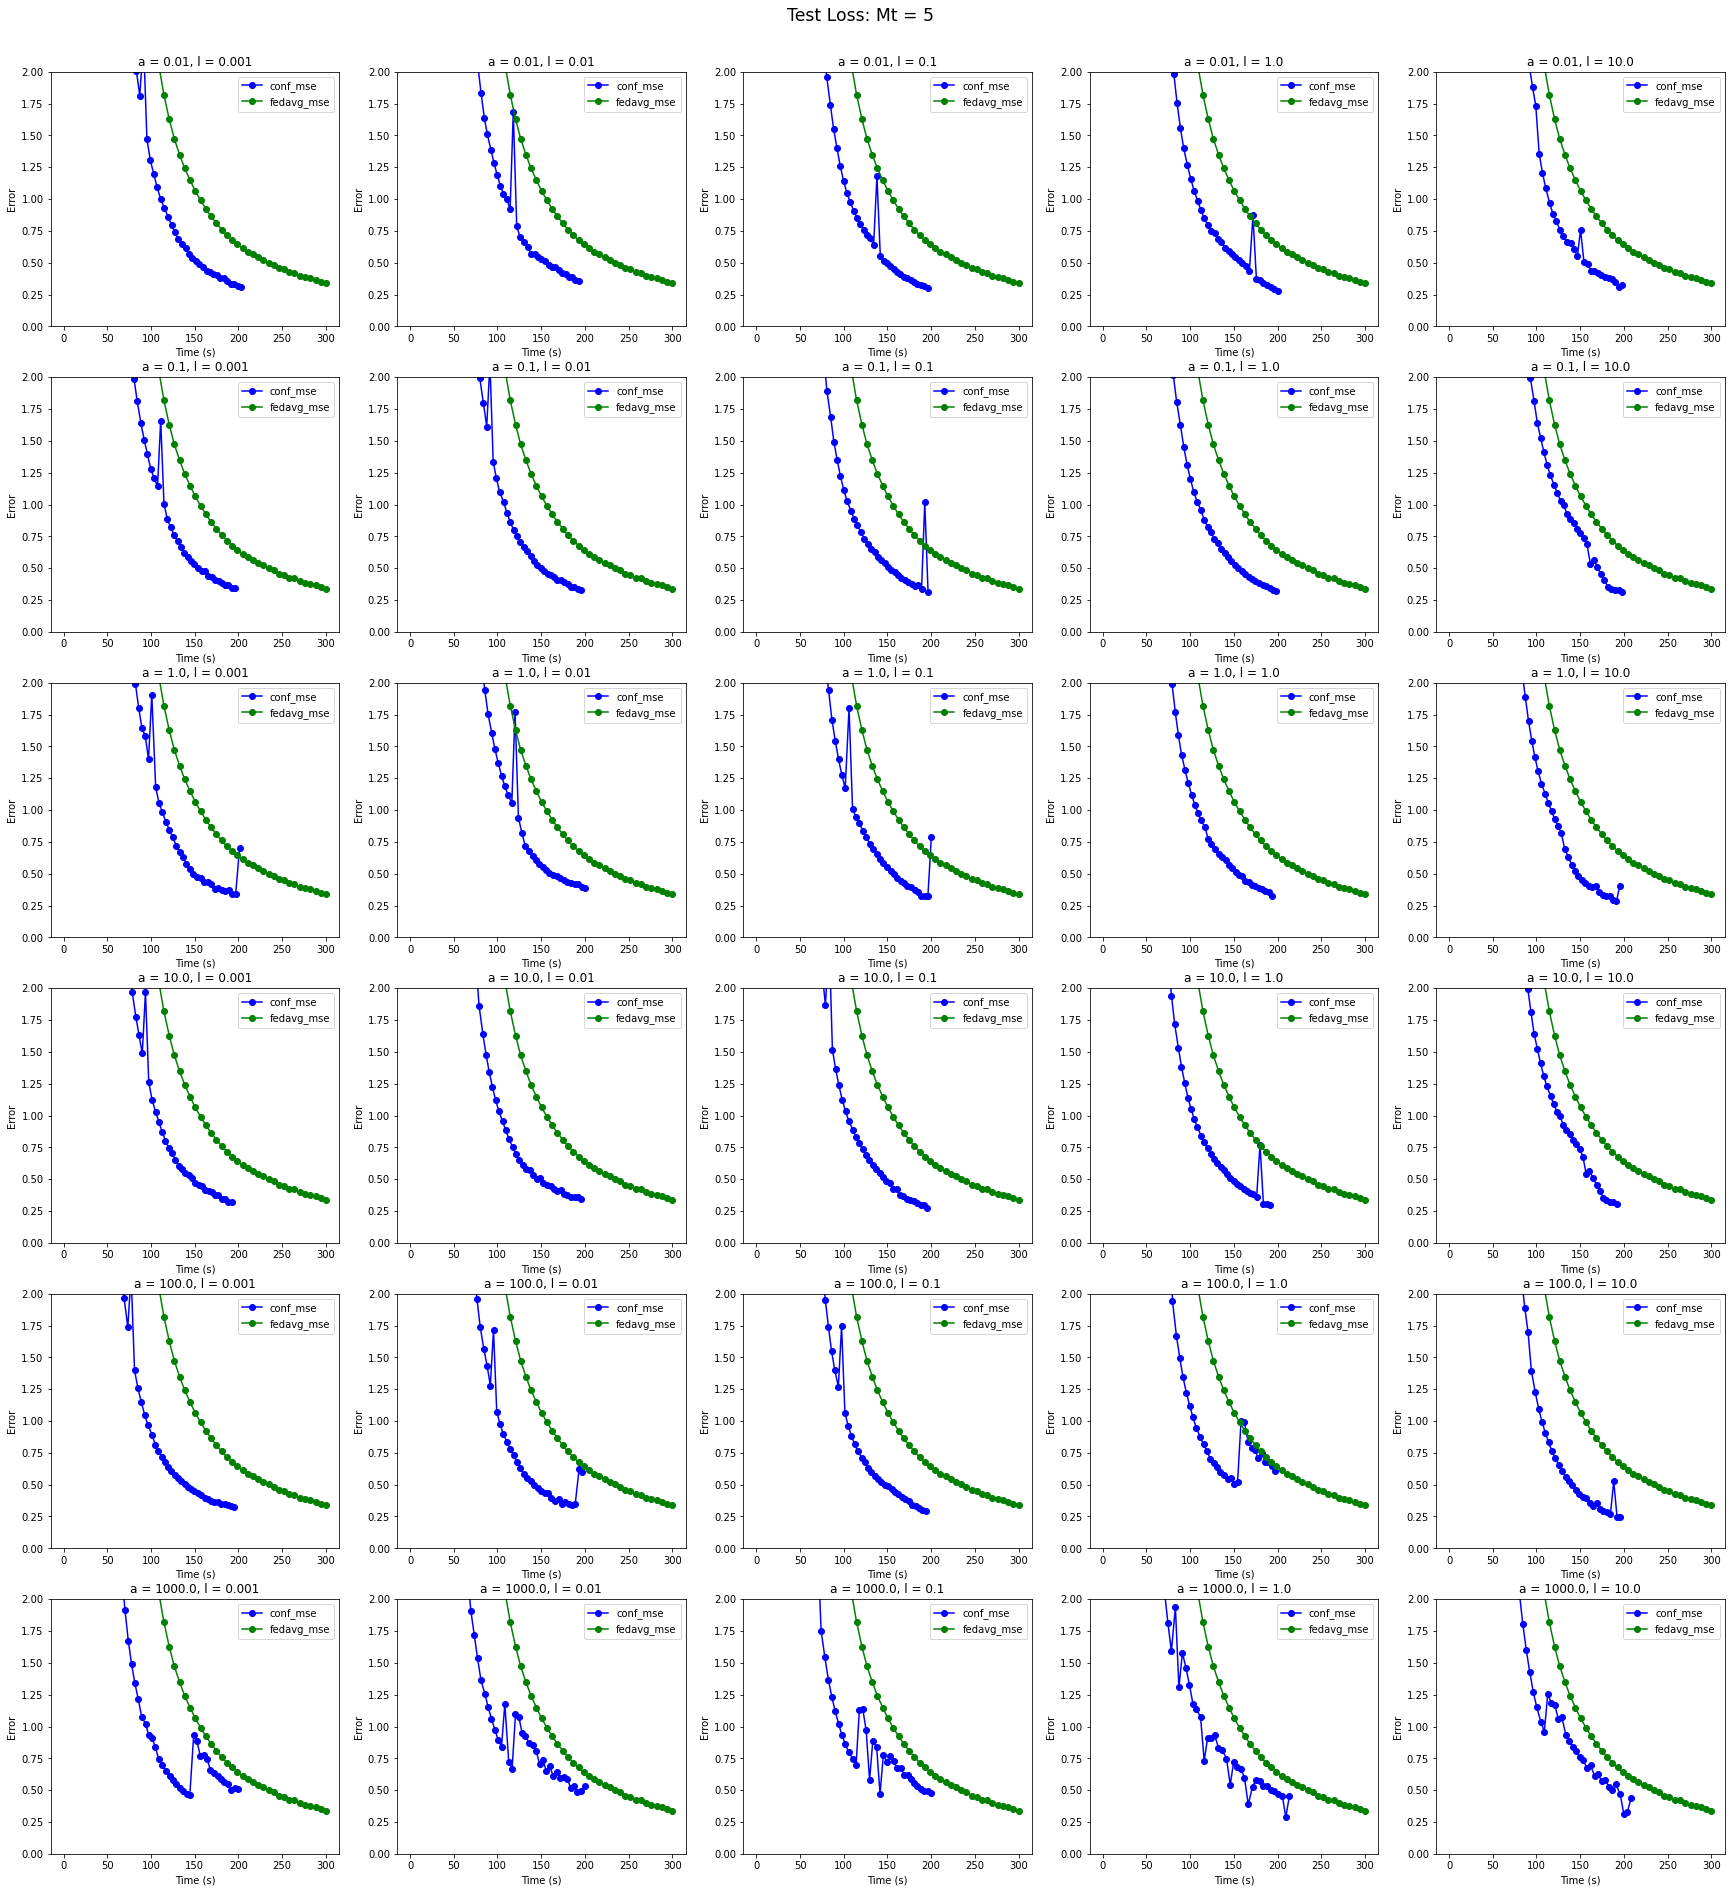

In [13]:
r, c, = 6, 5
fig = plt.figure(figsize = (30, 30))
plt.suptitle('Test Loss: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)

print(f'Final FedAvg Test MSE: {fedavg_test_mse[-1]}')

plot = 1
for run in history.items():
    a, l = run[0]
    err, time =  run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_test_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
    plt.title(f'a = {a}, l = {l}')
    plt.ylim(0, 2)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.legend()

    print(f'a = {a}, l = {l}, Final mse: {err[-1]}, {fedavg_test_mse[-1] > err[-1]}')

    plot += 1

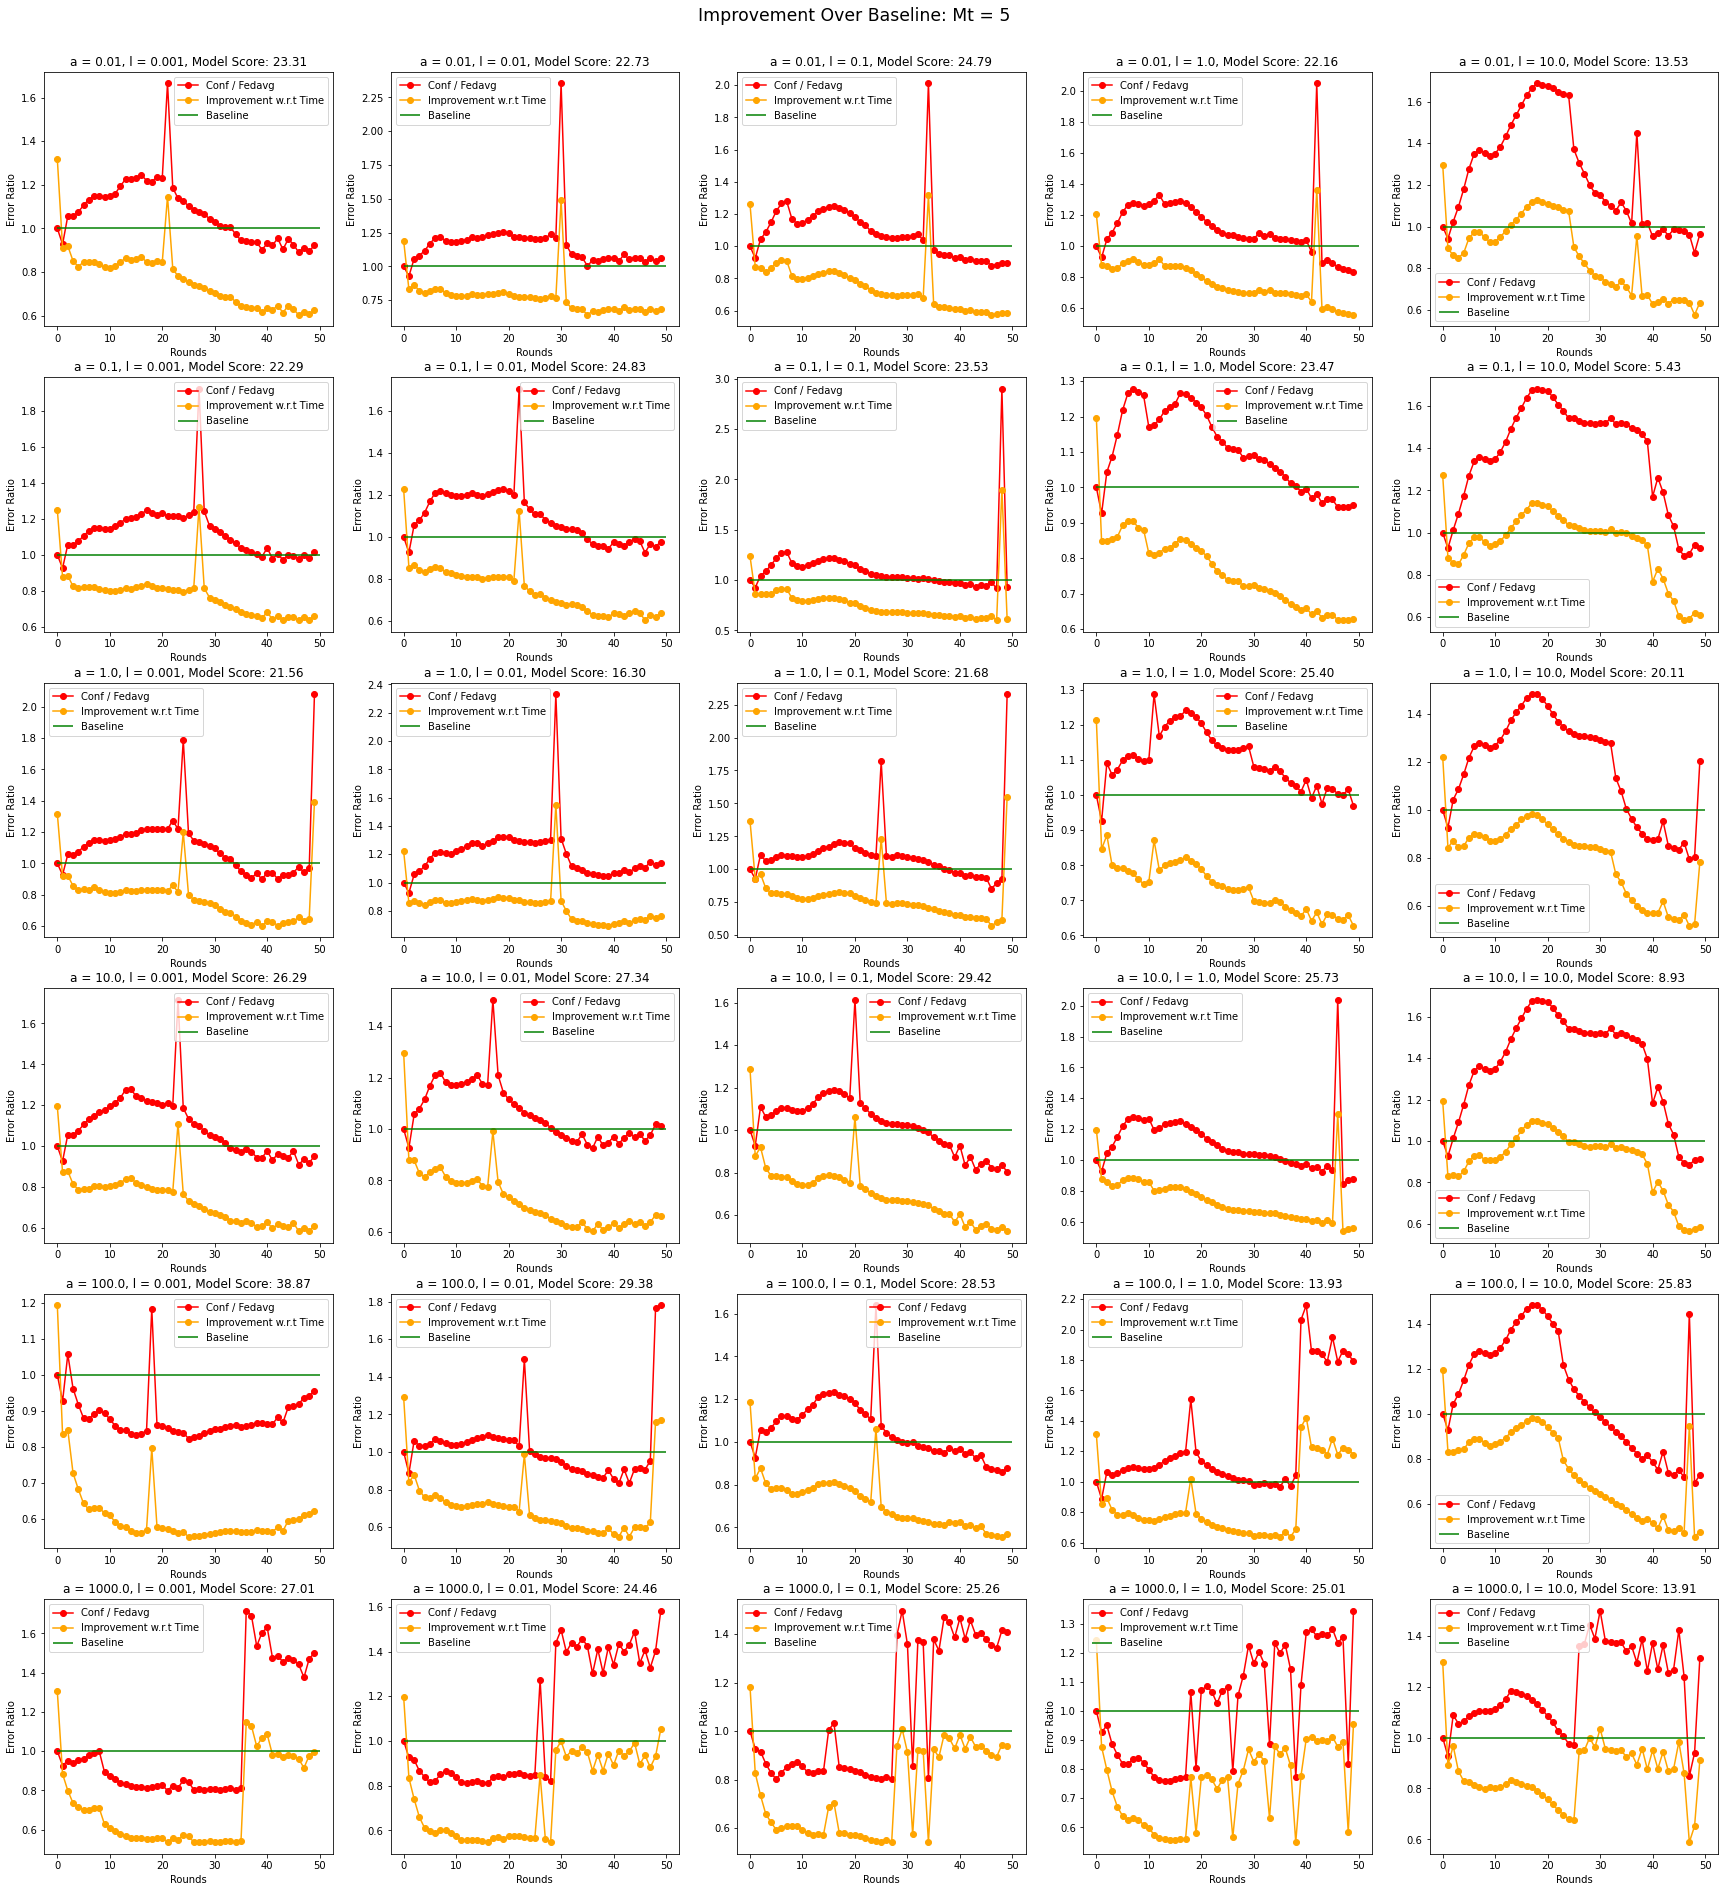

In [14]:
r, c, = 6, 5
fig = plt.figure(figsize = (30, 30))
plt.suptitle('Improvement Over Baseline: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)

plot = 1
for run in history.items():
    a, l = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)

    ratios = np.array(err[1:]) / np.array(fedavg_test_mse[1:]) 
    scale = np.array(time[1:]) / np.array(fedavg_log[1:])
    timescaled = scale * ratios
    plt.plot(ratios, color = 'red', label = 'Conf / Fedavg', marker = 'o')
    score = 1 - timescaled.mean()
    if score < 0: score = 0
    plt.title(f'a = {a}, l = {l}, Model Score: {score * 100:.2f}')
    plt.ylabel('Error Ratio')
    plt.xlabel('Rounds')
    plt.hlines(1, 0, 50, color = 'green', label = 'Baseline')
    plt.legend()


    plot += 1

# Ablation Study: $\alpha = 0.01$ and $\lambda = 0.01$

In [15]:
history = dict()
base_mse = dict()
base_log = dict()
Mt = (np.ones(50) * 5).astype('int32')

context_elements = [
    [0, 1, 2, 3, 4],
    [0],
    [1],
    [2],
    [3],
    [4],
    [1, 2, 3, 4],
    [0, 2, 3, 4],
    [0, 1, 3, 4],
    [0, 1, 2, 4],
    [0, 1, 2, 3]
]

In [16]:
count = 1
for context in context_elements:
    print(f'Training Model {count}')
    fed.SetContextElements(context)
    w, b = fed.ConFeddi(.01, .01, rounds = 50, Mt = Mt)
    mse = fed.test_loss()
    log = fed.GetLog()
    history[tuple(context)] = (mse, log)
    count += 1

    if context == [0, 1, 2, 3, 4]:
        base_mse[tuple(context)] = mse
        base_log[tuple(context)] = log
    fed.clear_history()
    print()

Training Model 1
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 2
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 3
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 4
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 5
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 6
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 7
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 8
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 9
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50

Training Model 10
Round 5
Round 10
Ro

Final FedAvg: 0.3371109366416931
context = (0,), True, Final Test Error: 0.24789461493492126
context = (1,), False, Final Test Error: 0.6350897550582886
context = (2,), False, Final Test Error: 0.42458629608154297
context = (3,), False, Final Test Error: 0.4002545177936554
context = (4,), False, Final Test Error: 0.46559613943099976
context = (1, 2, 3, 4), False, Final Test Error: 0.8348538279533386
context = (0, 2, 3, 4), False, Final Test Error: 0.8084357976913452
context = (0, 1, 3, 4), False, Final Test Error: 0.6867631077766418
context = (0, 1, 2, 4), True, Final Test Error: 0.3335462808609009
context = (0, 1, 2, 3), False, Final Test Error: 0.36270391941070557


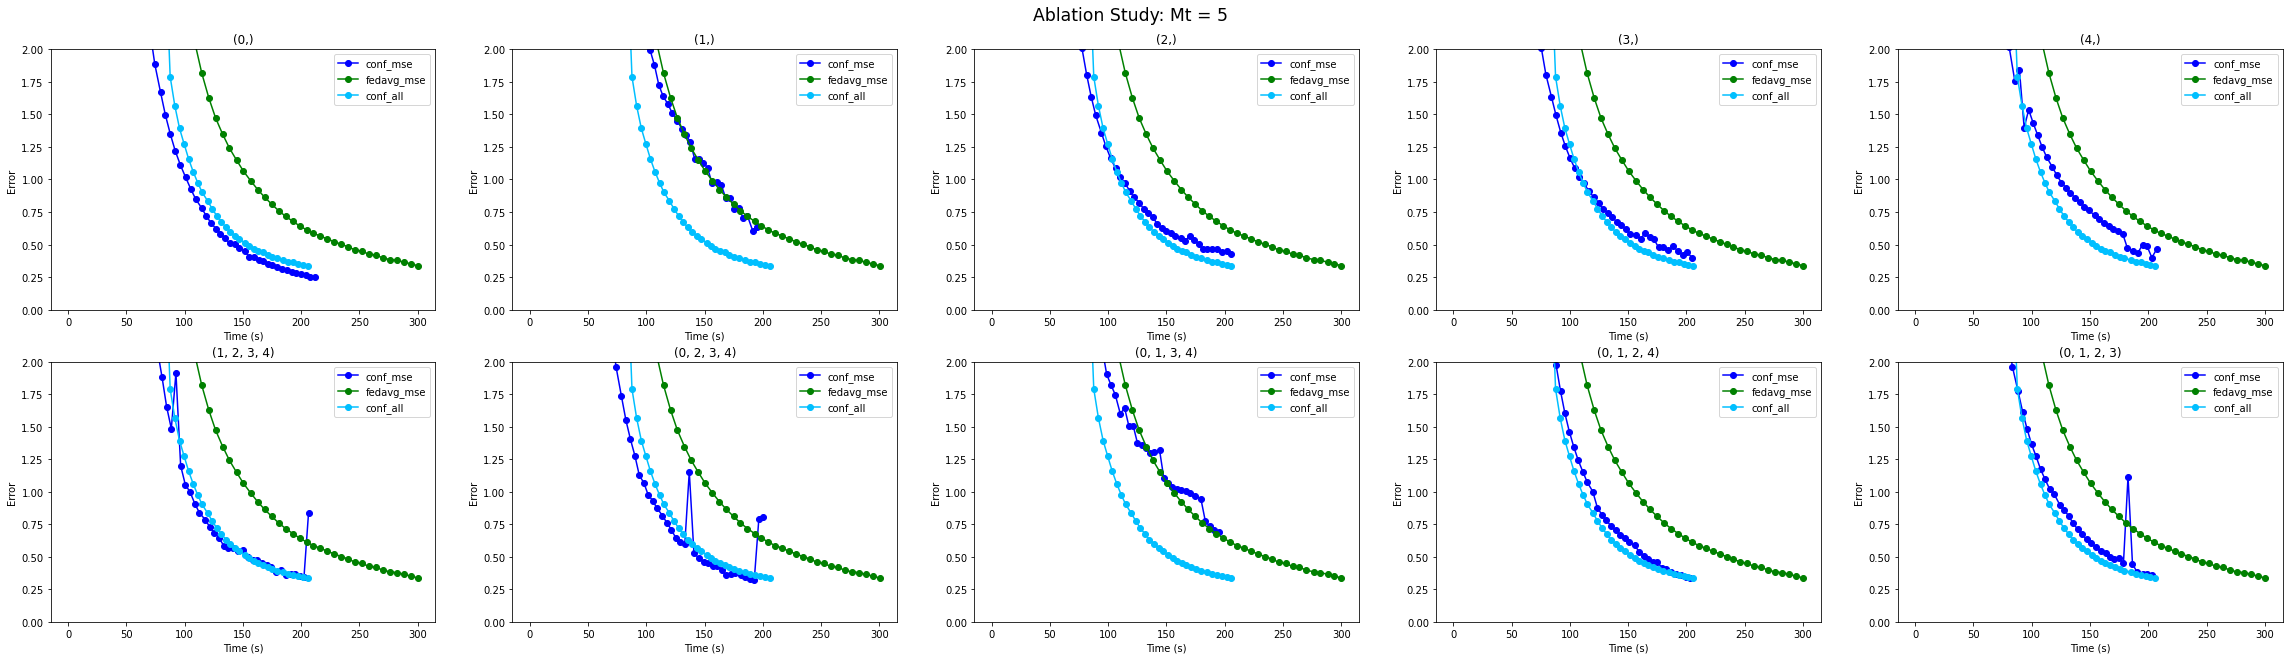

In [17]:
r, c, = 2, 5
fig = plt.figure(figsize = (40, 10))
plt.suptitle('Ablation Study: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)
print(f'Final FedAvg: {fedavg_test_mse[-1]}')

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)
    plt.plot(time, err, color = 'blue', label = 'conf_mse', marker = 'o')
    plt.plot(fedavg_log, fedavg_test_mse, color = 'green', label = 'fedavg_mse', marker = 'o')
    

    plt.plot(base_log[tuple([0, 1, 2, 3, 4])], base_mse[tuple([0, 1, 2, 3, 4])], color = 'deepskyblue', label = 'conf_all', marker = 'o')

    # When using final a and l, change title to Remove <specific context>
    plt.title(f'{context}')
    plt.ylim(0, 2)
    plt.ylabel('Error')
    plt.xlabel('Time (s)')
    plt.legend()

    print(f'context = {context}, {fedavg_test_mse[-1] > err[-1]}, Final Test Error: {err[-1]}')

    plot += 1

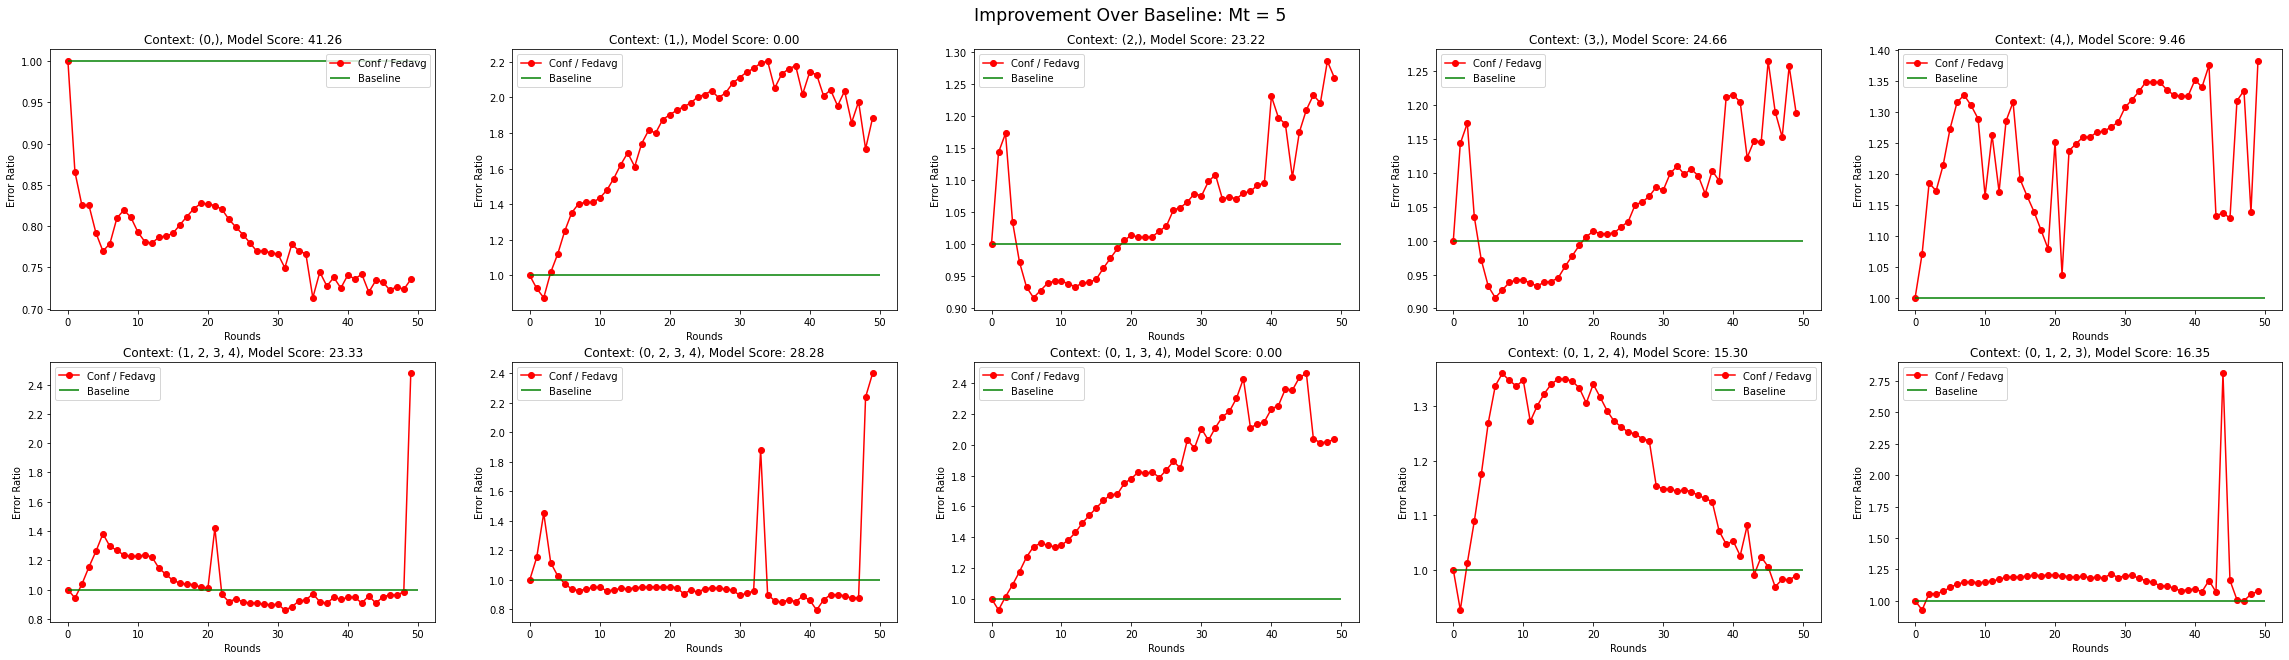

In [29]:
r, c, = 2, 5
fig = plt.figure(figsize = (40, 10))
plt.suptitle('Improvement Over Baseline: Mt = 5', fontsize = 'xx-large')
fig.tight_layout()
fig.subplots_adjust(top = 0.92)

plot = 1
for run in list(history.items())[1:]:
    context = run[0]
    err, time = run[1]
    fig.add_subplot(r, c, plot)

    ratios = np.array(err[1:]) / np.array(fedavg_test_mse[1:]) 
    scale = np.array(time[1:]) / np.array(fedavg_log[1:])
    timescaled = scale * ratios
    plt.plot(ratios, color = 'red', label = 'Conf / Fedavg', marker = 'o')
    #plt.plot(timescaled, color = 'red', label = 'Improvement w.r.t Time', marker = 'o')
    score = 1 - timescaled.mean()
    if score < 0: score = 0
    plt.title(f'Context: {context}, Model Score: {score * 100:.2f}')
    plt.ylabel('Error Ratio')
    plt.xlabel('Rounds')
    plt.hlines(1, 0, 50, color = 'green', label = 'Baseline')
    plt.legend()


    plot += 1

In [38]:
Mt = (np.ones(50) * 5).astype('int32')
fed.SetContextElements([0, 4])
w, b = fed.ConFeddi(0.01, 0.01, rounds = 50, Mt = Mt)
conf_test_mse = fed.test_loss()
conf_log = fed.GetLog()
fed.clear_history()

[-1.56035211 -0.0309776  -0.62092842 -1.46458049  1.41194612 -0.47673214
 -0.78046921  1.07026774 -1.2822926  -1.3274789   0.12633764  0.86219372
  0.69673696 -0.33456518 -0.99752606  1.59890829  3.31407535  0.98777046
  0.12386626  0.74278539 -0.39395585  0.14811582 -0.41223445 -0.16071506
  0.13953147  0.28546937 -0.28126199  1.71090732 -0.14976664  0.69030672
  1.09520951  1.3384087 ]
Round 5
Round 10
Round 15
Round 20
Round 25
Round 30
Round 35
Round 40
Round 45
Round 50


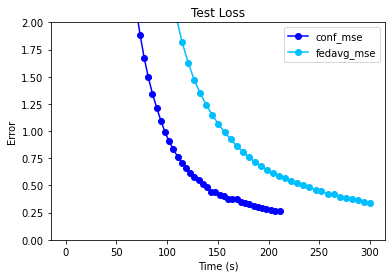

In [39]:
plt.ylim(0, 2)
plt.plot(conf_log, conf_test_mse, color = 'blue', label = 'conf_mse', marker = 'o')
plt.plot(fedavg_log, fedavg_test_mse, color = 'deepskyblue', label = 'fedavg_mse', marker = 'o')
plt.title(f'Test Loss')
plt.ylabel('Error')
plt.xlabel('Time (s)')
plt.legend()

In [40]:
print(f'Final FedAvg Test MSE: {fedavg_test_mse[-1]}')
print(f'Final ConFeddi Test MSE: {conf_test_mse[-1]}')

Final FedAvg Test MSE: 0.3371109366416931
Final ConFeddi Test MSE: 0.2607792317867279
